In [1]:
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import BatchNormalization
from tensorflow.keras.models import Model
#import random as rn
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import datetime 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
! pip install kaggle

In [11]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle competitions download plant-pathology-2020-fgvc7

 98% 764M/779M [00:06<00:00, 197MB/s]
100% 779M/779M [00:06<00:00, 123MB/s]


In [15]:
! unzip plant-pathology-2020-fgvc7.zip

Archive:  plant-pathology-2020-fgvc7.zip
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflating: images/Test_1018.jpg    
  inflating: images/Test_1019.jpg    
  inflati

In [2]:
df = pd.read_csv('train.csv')

In [3]:
dir_path = "images"

In [4]:
list_of_train_data = []
for i in df.image_id:
    list_of_train_data.append(os.path.join(dir_path,i+".jpg"))

In [5]:
train_image_labels = []
for i in df.values:
    train_image_labels.append(np.where(i[1:]==1)[0][0])

## Train Test Split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(list_of_train_data, train_image_labels, test_size = 0.25, stratify = train_image_labels, random_state = 30)

## Image Generator

In [8]:
def tfdata_generator(images, labels, is_training, batch_size=32):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, label):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        #resize the image
        #image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, [156, 256])
        #one hot coding for label
        
        if is_training:
            if np.random.uniform(0,1) > 0.6:
                image = tf.image.random_hue(image, 0.08)
                image = tf.image.random_saturation(image, 0.6, 1.6)
                image = tf.image.random_brightness(image, 0.05)
                image = tf.image.random_contrast(image, 0.7, 1.3)
        
            elif np.random.uniform(0,1) > 0.6:
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_flip_up_down(image)
            
        y = tf.one_hot(tf.cast(label, tf.uint8), 4)
        return image, y
    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    if is_training:
        dataset = dataset.shuffle(48000)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=4,  # cpu cores
        drop_remainder=True if is_training else False))
    
    #repeat the dataset indefinitely
    dataset = dataset.repeat() #**********************************

    
    #prefetch the data into CPU/GPU
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [9]:
train_image_generator = tfdata_generator(x_train, y_train, True, batch_size=32)
test_image_generator = tfdata_generator(x_test, y_test, False, batch_size=32)

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [7]:
def auc_score(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

In [8]:
#AUC score
def auc( y_true, y_pred ) :
    score = tf.py_function( auc_score,[y_true, y_pred],'float32',name='sklearnAUC' )
    return score

In [9]:
def confusion_matrix_(x_train, y_train):
    b = np.empty((0,4),float)
    for i in tqdm(x_train):
        image_string = tf.io.read_file(i)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)
        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        #resize the image
        image = tf.image.resize(image, [156, 256])
        #print(image.shape)
        image = tf.expand_dims(image, axis=0)
        prediction = np.where(model.predict(image)[0] == model.predict(image)[0].max(), 1, 0)
        b = np.concatenate((b, np.array([np.array(prediction)])), axis=0)
        
    actual = np.array(tf.one_hot(tf.cast(y_train, tf.uint8), 4))
    actual_healthy = np.choose([0], actual.T)
    actual_multiple_diseases = np.choose([1], actual.T)
    actual_rust = np.choose([2], actual.T)
    actual_scab = np.choose([3], actual.T)

    predicted_healthy = np.choose([0], b.T)
    predicted_multiple_diseases = np.choose([1], b.T)
    predicted_rust = np.choose([2], b.T)
    predicted_scab = np.choose([3], b.T)
    
    plt.figure(figsize=(10,10))
    cm = confusion_matrix(actual_healthy, predicted_healthy,labels=[0,1])
    cmap=sns.light_palette("blue")
    plt.subplot(221)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".3f", xticklabels = ['Not Healthy','Healthy'], yticklabels = ['Not Healthy','Healthy'])


    cm = confusion_matrix(actual_multiple_diseases, predicted_multiple_diseases,labels=[0,1])
    cmap=sns.light_palette("blue")
    plt.subplot(222)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".3f", xticklabels = ['No Multiple Diseases','Multiple Diseases'], yticklabels = ['No Multiple Diseases','Multiple Diseases'])
    

    cm = confusion_matrix(actual_rust, predicted_rust,labels=[0,1])
    cmap=sns.light_palette("blue")
    plt.subplot(223)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".3f", xticklabels = ['Not Rusty','Rusty'], yticklabels = ['Not Rusty','Rusty'])

    cm = confusion_matrix(actual_scab, predicted_scab,labels=[0,1])
    cmap=sns.light_palette("blue")
    plt.subplot(224)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".3f", xticklabels = ['Not Scaby','Scaby'], yticklabels = ['Not Scaby','Scaby'])
    
    plt.show()


# Baseline Model - 1

In [10]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

In [15]:
log_dir1 = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir1,histogram_freq=1,write_graph=True)

In [16]:
input_layer = Input([156, 256, 3])
conv_1 = Conv2D(filters = 16, kernel_size = (3,3))(input_layer)
flattened = Flatten()(conv_1)
out_layer = Dense(units=4, activation = 'softmax')(flattened)

In [17]:
model = Model(inputs = input_layer, outputs = out_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 156, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 154, 254, 16)      448       
_________________________________________________________________
flatten (Flatten)            (None, 625856)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2503428   
Total params: 2,503,876
Trainable params: 2,503,876
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=[auc])

In [19]:
model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=10, validation_data=test_image_generator, validation_steps=len(x_test)//32 , callbacks=[tensorboard_callback] )

Epoch 1/10
42/42 [==============================] - 40s 783ms/step - loss: 25.1297 - auc: 0.5249 - val_loss: 4.5344 - val_auc: 0.5418
Epoch 2/10
42/42 [==============================] - 34s 829ms/step - loss: 1.8370 - auc: 0.6975 - val_loss: 1.5155 - val_auc: 0.6113
Epoch 3/10
42/42 [==============================] - 32s 763ms/step - loss: 0.6828 - auc: 0.8468 - val_loss: 1.7201 - val_auc: 0.5941
Epoch 4/10
42/42 [==============================] - 34s 805ms/step - loss: 0.4033 - auc: 0.8692 - val_loss: 1.5460 - val_auc: 0.6030
Epoch 5/10
42/42 [==============================] - 33s 800ms/step - loss: 0.2334 - auc: 0.8903 - val_loss: 1.4739 - val_auc: 0.6099
Epoch 6/10
42/42 [==============================] - 33s 801ms/step - loss: 0.1650 - auc: 0.9158 - val_loss: 1.5714 - val_auc: 0.6229
Epoch 7/10
42/42 [==============================] - 42s 1s/step - loss: 0.1081 - auc: 0.9167 - val_loss: 1.5684 - val_auc: 0.6165
Epoch 8/10
42/42 [==============================] - 33s 800ms/step - lo

In [20]:
%tensorboard --logdir=logs/

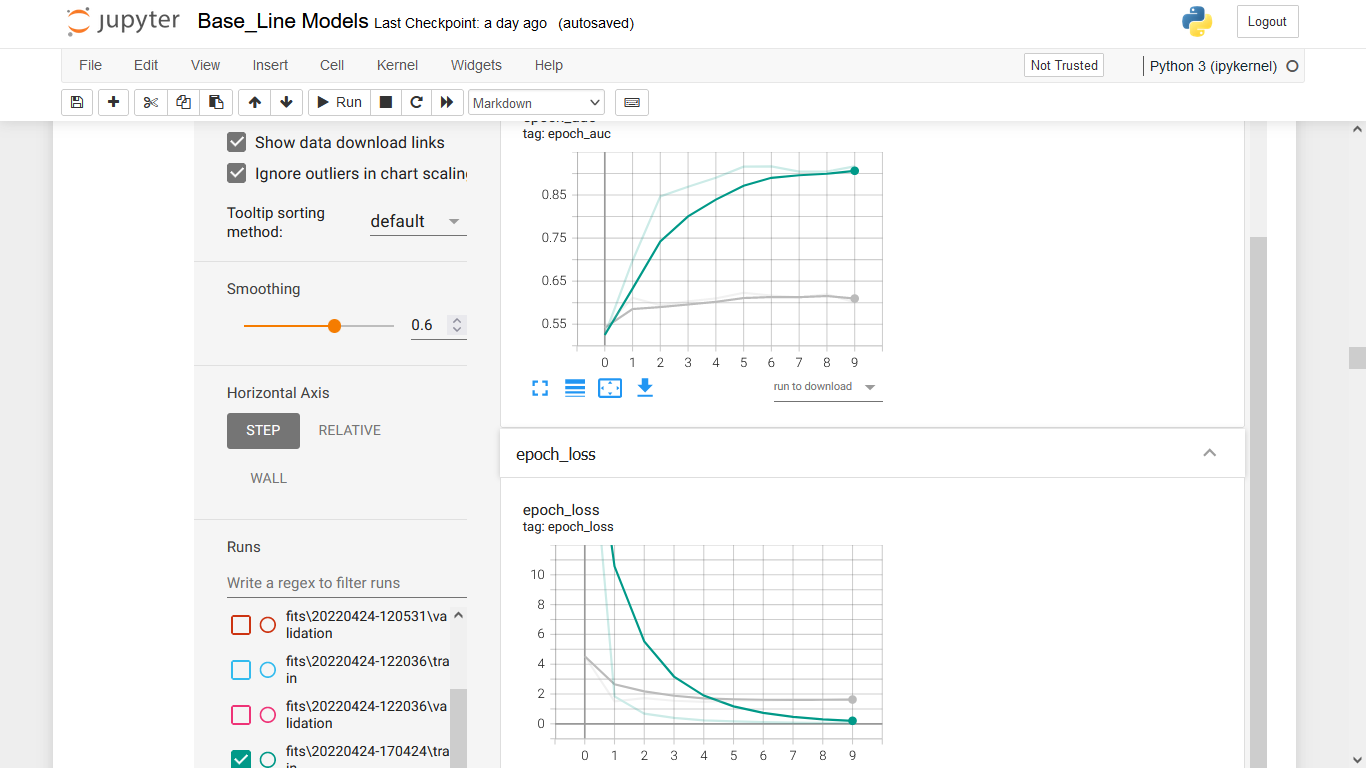

### Kaggle Score for the above - 0.56159

100%|████████████████████████████████████████████████████████████████████████████████| 456/456 [00:52<00:00,  8.69it/s]


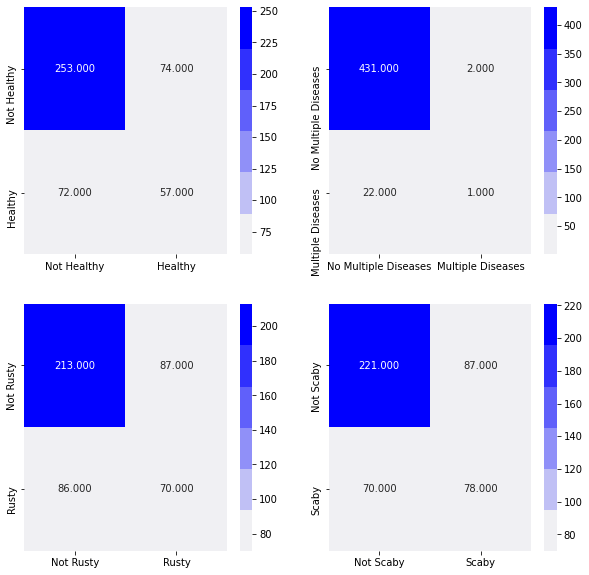

In [21]:
confusion_matrix_(x_test, y_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1365/1365 [02:30<00:00,  9.06it/s]


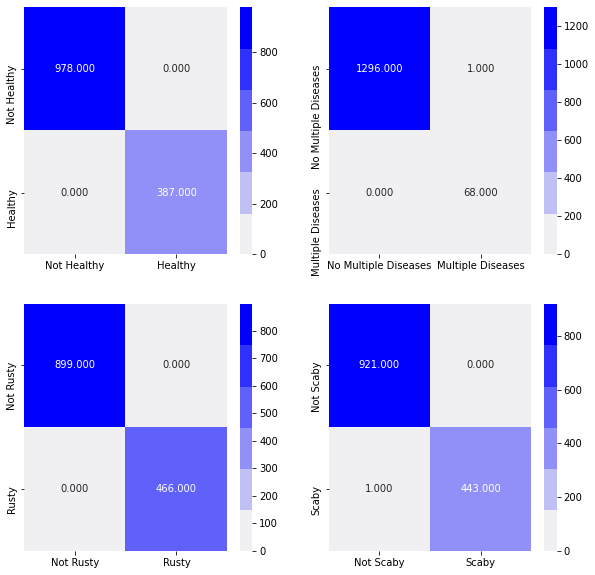

In [22]:
confusion_matrix_(x_train, y_train)

# Baseline Model - 2

### Resnet50 Model, model.trainable = False

In [12]:
base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet", input_shape=(156, 256, 3))
base_model.trainable = False

In [13]:
log_dir1 = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir1,histogram_freq=1,write_graph=True)

In [14]:
conv_1 = Conv2D(filters = 16, kernel_size = (3,3))(base_model.layers[-1].output)
flattened = Flatten()(conv_1)
out_layer = Dense(units=4, activation = 'softmax')(flattened)

In [15]:
model = Model(inputs = base_model.layers[0].input, outputs = out_layer)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=[auc])

In [17]:
model.fit(train_image_generator, steps_per_epoch=len(x_train)//32, epochs=10, validation_data=test_image_generator, validation_steps=len(x_test)//32, callbacks=[tensorboard_callback] )

C:\Users\dhira\Anaconda3\envs\tf2.6\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10
42/42 [==============================] - 78s 2s/step - loss: 2.3159 - auc: 0.5675 - val_loss: 1.6520 - val_auc: 0.5813
Epoch 2/10
42/42 [==============================] - 66s 2s/step - loss: 1.2615 - auc: 0.6349 - val_loss: 1.2517 - val_auc: 0.6318
Epoch 3/10
42/42 [==============================] - 66s 2s/step - loss: 1.2597 - auc: 0.6676 - val_loss: 1.3392 - val_auc: 0.6368
Epoch 4/10
42/42 [==============================] - 66s 2s/step - loss: 1.1701 - auc: 0.6871 - val_loss: 1.1570 - val_auc: 0.6453
Epoch 5/10
42/42 [==============================] - 66s 2s/step - loss: 1.1761 - auc: 0.6898 - val_loss: 1.4926 - val_auc: 0.6439
Epoch 6/10
42/42 [==============================] - 69s 2s/step - loss: 1.1330 - auc: 0.7111 - val_loss: 1.1924 - val_auc: 0.6597
Epoch 7/10
42/42 [==============================] - 66s 2s/step - loss: 1.0877 - auc: 0.7221 - val_loss: 1.2274 - val_auc: 0.6531
Epoch 8/10
42/42 [==============================] - 66s 2s/step - loss: 1.0319 - auc: 0.74

In [18]:
%tensorboard --logdir=logs/

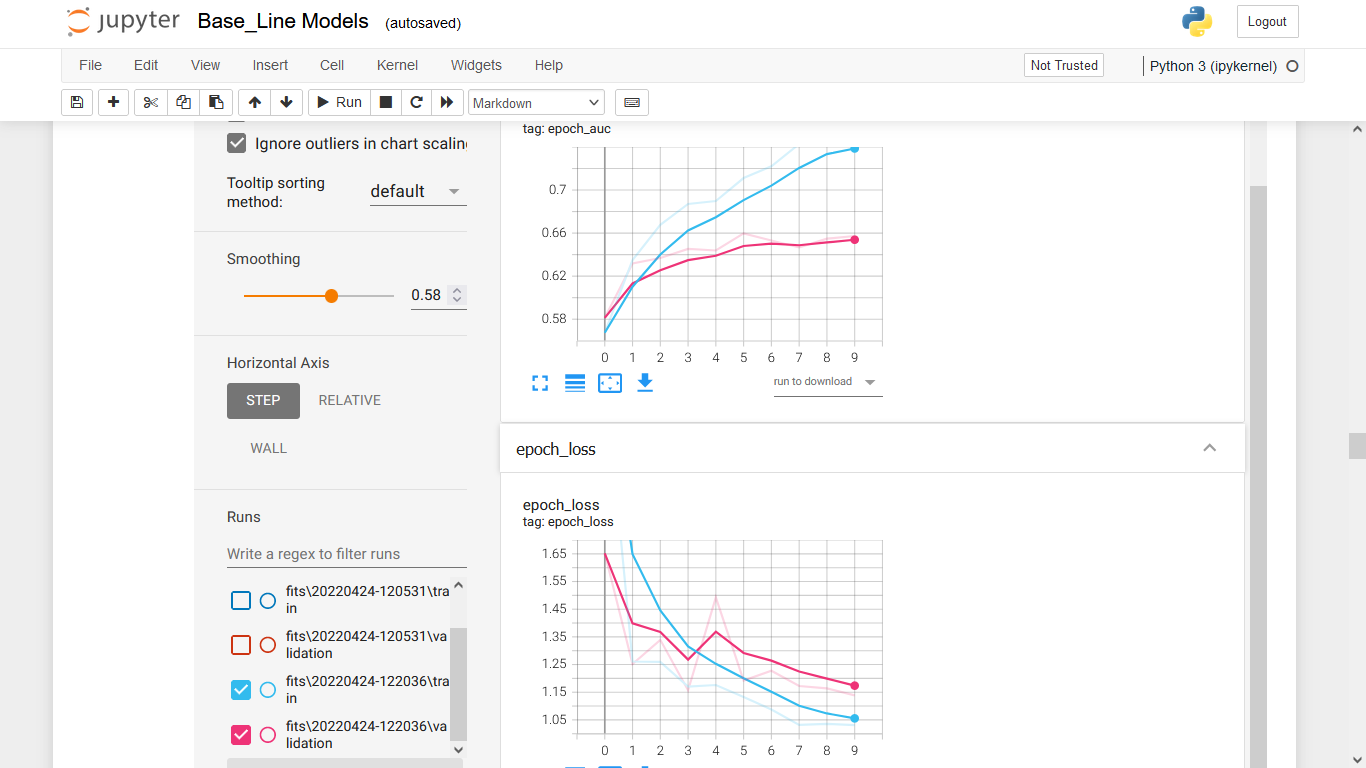

### Kaggle Score for the above 0.63478

100%|████████████████████████████████████████████████████████████████████████████████| 456/456 [02:19<00:00,  3.26it/s]


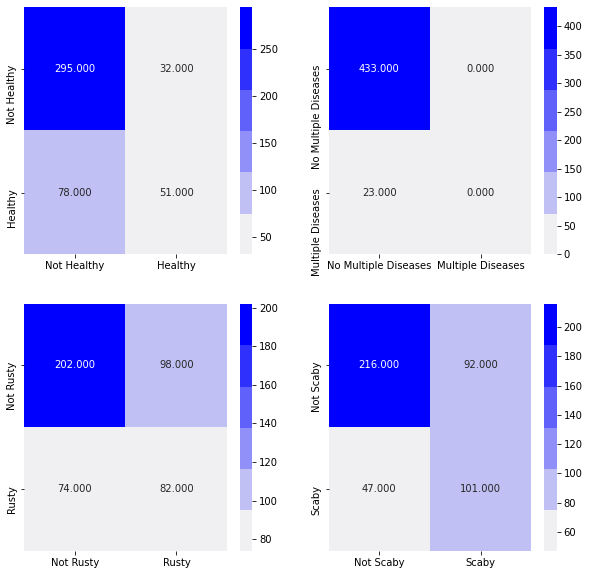

In [199]:
confusion_matrix_(x_test, y_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1365/1365 [09:36<00:00,  2.37it/s]


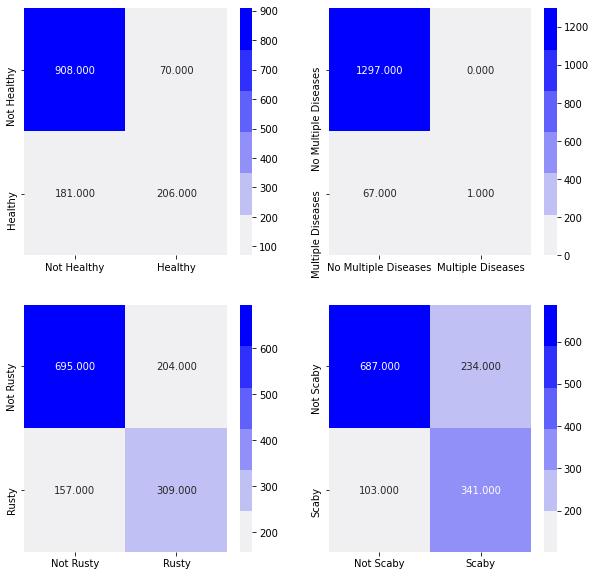

In [200]:
confusion_matrix_(x_train, y_train)

#### The Model is performing reasonably for majority class, but performing poorly in case of minoirty class

# Baseline Model - 3

The submission made with equal probability for all the classes, gave a Kaggle score of 0.5

## Creating Sample Submission File

In [22]:
df_test = pd.read_csv('test.csv')

In [23]:
##Getting image directories
list_of_test_data = []
for i in df_test.image_id:
    list_of_test_data.append(os.path.join(dir_path,i+".jpg"))

In [24]:
##Getting image names
test_data = []
for i in df_test.image_id:
    test_data.append(i)

In [ ]:
a = np.empty((0,4),float)
for i in list_of_test_data:
    image_string = tf.io.read_file(i)
    #decoding image
    image = tf.image.decode_jpeg(image_string, channels=3)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    #resize the image
    image = tf.image.resize(image, [156, 256])
    #print(image.shape)
    image = tf.expand_dims(image, axis=0)
    a = np.concatenate((a,model.predict(image)), axis=0)

In [ ]:
b = pd.DataFrame(a)
b['image_id'] = test_data
b.columns= ['healthy', 'multiple_diseases', 'rust', 'scab', 'image_id'] # Naming the columns
b = b[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']] # Reodering the column
b.set_index('image_id')

,healthy,multiple_diseases,rust,scab
image_id,,,,
Test_0,0.056386,0.019984,0.637263,0.286368
Test_1,0.109352,0.010220,0.714925,0.165503
Test_2,0.136418,0.015221,0.511823,0.336537
Test_3,0.194777,0.020580,0.604363,0.180280
Test_4,0.109701,0.041536,0.678369,0.170394
...,...,...,...,...
Test_1816,0.146081,0.041121,0.546599,0.266199
Test_1817,0.297351,0.038765,0.441061,0.222824
Test_1818,0.083337,0.033383,0.500340,0.382941


In [ ]:
b.to_csv('sub1.csv')